In [1]:
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torch.testing._internal import common_dtype
from torch.cuda import amp

import numpy as np
import numpy.typing as npt

import esm

import os

import linecache

from typing import List, Tuple, Union, Sequence

from sklearn import model_selection

torch.set_num_threads(12)

During training, sequences longer than 1023 tokens (without CLS) are randomly cropped to a length of 1023.

The details of the masking procedure for each sequence follow Devlin et al. 2019:

15% of the amino acids are masked.
In 80% of the cases, the masked amino acids are replaced by `<mask>`. <br>
In 10% of the cases, the masked amino acids are replaced by a random amino acid (different) from the one they replace. <br>
In the 10% remaining cases, the masked amino acids are left as is. 

https://huggingface.co/facebook/esm-1b

Pre-training task: The masked language modeling pre-training task follows Devlin et al. (14). Specifically, we select as supervision 15% of tokens randomly sampled from the sequence. For those 15% of tokens, we change the input token to a special “masking” token with 80% probability, a randomly-chosen alternate amino acid token with 10% probability, and the original input token (i.e. no change) with 10% probability. We take the loss to be the whole batch average cross entropy loss between the model’s predictions and the true token for these 15% of amino acid tokens. In contrast to Devlin et al. (14), we do not use any additional auxiliary prediction losses.

Our model was pre-trained using a context size of 1024 tokens. As most Uniparc sequences (96.7%) contain fewer than 1024 amino acids, the Transformer is able to model the entire context in a single model pass. For those sequences that are longer than 1024 to- kens, we sampled a random crop of 1024 tokens during each training epoch. The model was optimized using Adam (β1 = 0.9, β2 = 0.999) with learning rate 10−4. We trained with 131,072 tokens per batch (128 gpus x 1024 tokens). The models follow a warm-up period of 16000 updates, during which the learning rate increases linearly. Afterwards, the learning rate follows an inverse square root decay schedule. All models were trained using the fairseq toolkit (Ott et al., 2019) on 128 NVIDIA V100 GPUs.

https://www.pnas.org/doi/full/10.1073/pnas.2016239118


#### Alex notes:
    - https://fairseq.readthedocs.io/en/latest/_modules/fairseq/optim/lr_scheduler/inverse_square_root_schedule.html likely used to implement learning rate decay after warmup
    - betas are defaults for Adam
    - only one "sequence" per GPU, sequence-wise batch size of 128
    - 

In [2]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
#batch_converter = alphabet.get_batch_converter()
#del model
print(*enumerate(alphabet.all_toks), sep='\n')

(0, '<cls>')
(1, '<pad>')
(2, '<eos>')
(3, '<unk>')
(4, 'L')
(5, 'A')
(6, 'G')
(7, 'V')
(8, 'S')
(9, 'E')
(10, 'R')
(11, 'T')
(12, 'I')
(13, 'D')
(14, 'P')
(15, 'K')
(16, 'Q')
(17, 'N')
(18, 'F')
(19, 'Y')
(20, 'M')
(21, 'H')
(22, 'W')
(23, 'C')
(24, 'X')
(25, 'B')
(26, 'U')
(27, 'Z')
(28, 'O')
(29, '.')
(30, '-')
(31, '<null_1>')
(32, '<mask>')


In [3]:
model = esm.model.esm1.ProteinBertModel(model.args, alphabet)

In [4]:
file_path = '/work/ucsf/ntranos/variant-gsp1/first-1M-tokens.txt'

In [5]:
def unravel_index(  # see https://github.com/pytorch/pytorch/issues/35674; left in codebase unused because it will probably be useful
    indices: torch.Tensor,
    shape: Union[int, Sequence, torch.Tensor],
    *,
    as_tuple: bool = True,
) -> Union[Tuple[torch.Tensor, ...], torch.Tensor]:
    
    r"""Converts a `Tensor` of flat indices into a `Tensor` of coordinates for the given target shape.
    Args:
        indices: An integral `Tensor` containing flattened indices of a `Tensor` of dimension `shape`.
        shape: The shape (can be an `int`, a `Sequence` or a `Tensor`) of the `Tensor` for which
               the flattened `indices` are unraveled.
    Keyword Args:
        as_tuple: A boolean value, which if `True` will return the result as tuple of Tensors,
                  else a `Tensor` will be returned. Default: `True`
    Returns:
        unraveled coordinates from the given `indices` and `shape`. See description of `as_tuple` for
        returning a `tuple`.
    .. note:: The default behaviour of this function is analogous to
              `numpy.unravel_index <https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html>`_.
    Example::
        >>> indices = torch.tensor([22, 41, 37])
        >>> shape = (7, 6)
        >>> torch.unravel_index(indices, shape)
        tensor([[3, 4],
                [6, 5],
                [6, 1]])
        >>> torch.unravel_index(indices, shape)
        (tensor([3, 6, 6]), tensor([4, 5, 1]))
        >>> indices = torch.tensor([3, 10, 12])
        >>> shape_ = (4, 2, 3)
        >>> torch.unravel_index(indices, shape_, as_tuple=False)
        tensor([[0, 1, 0],
                [1, 1, 1],
                [2, 0, 0]])
    """

    def _helper_type_check(inp: Union[int, Sequence, torch.Tensor], name: str):
        # `indices` is expected to be a tensor, while `shape` can be a sequence/int/tensor
        if name == "shape" and isinstance(inp, Sequence):
            for dim in inp:
                if not isinstance(dim, int):
                    raise TypeError("Expected shape to have only integral elements.")
                if dim < 0:
                    raise ValueError("Negative values in shape are not allowed.")
        elif name == "shape" and isinstance(inp, int):
            if inp < 0:
                raise ValueError("Negative values in shape are not allowed.")
        elif isinstance(inp, torch.Tensor):
            if inp.dtype not in common_dtype.integral_types():
                raise TypeError(
                    f"Expected {name} to be an integral tensor, but found dtype: {inp.dtype}"
                )
            if torch.any(inp < 0):
                raise ValueError(f"Negative values in {name} are not allowed.")
        else:
            allowed_types = (
                "Sequence/Scalar (int)/Tensor" if name == "shape" else "Sequence/Tensor"
            )
            msg = f"{name} should either be a {allowed_types}, but found {type(inp)}"
            raise TypeError(msg)

    _helper_type_check(indices, "indices")
    _helper_type_check(shape, "shape")

    # Convert to a tensor, with the same properties as that of indices
    if isinstance(shape, Sequence):
        shape_tensor: Tensor = indices.new_tensor(shape)
    elif isinstance(shape, int) or (isinstance(shape, Tensor) and shape.ndim == 0):
        shape_tensor = indices.new_tensor((shape,))
    else:
        shape_tensor = shape

    # By this time, shape tensor will have dim = 1 if it was passed as scalar (see if-elif above)
    assert shape_tensor.ndim == 1, "Expected dimension of shape tensor to be <= 1, "
    f"but got the tensor with dim: {shape_tensor.ndim}."

    # In case no indices passed, return an empty tensor with number of elements = shape.numel()
    if indices.numel() == 0:
        # If both indices.numel() == 0 and shape.numel() == 0, short-circuit to return itself
        shape_numel = shape_tensor.numel()
        if shape_numel == 0:
            raise ValueError(
                "Got indices and shape as empty tensors, expected non-empty tensors."
            )
        else:
            output = [indices.new_tensor([]) for _ in range(shape_numel)]
            return tuple(output) if as_tuple else torch.stack(output, dim=1)

    if torch.max(indices) >= torch.prod(shape_tensor):
        raise ValueError("Target shape should cover all source indices.")

    coefs = shape_tensor[1:].flipud().cumprod(dim=0).flipud()
    coefs = torch.cat((coefs, coefs.new_tensor((1,))), dim=0)
    coords = torch.div(indices[..., None], coefs, rounding_mode="trunc") % shape_tensor

    if as_tuple:
        return tuple(coords[..., i] for i in range(coords.size(-1)))
    
    return coords


In [6]:
# alex code here

In [7]:
def random_crop_sequence(
        tokens: Union[torch.Tensor, npt.NDArray[int]], max_length: int, return_start: bool = False
    ):
        """
        Randomly crop a sequence of length `max_length` from tokens.
        """
        if isinstance(tokens, (torch.Tensor, np.ndarray)) is False:
            raise TypeError('Argument tokens must be of type torch.Tensor or np.ndarray.')
        
        start_index = np.random.randint(
            0, high=len(tokens) - max_length, size=1, dtype=int
        ).item()
        
        if return_start:
            return start_index, tokens[start_index : start_index + max_length]
        else:
            return tokens[start_index : start_index + max_length]

class AASequenceDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        file_path: Union[str, os.PathLike],
        aa_to_replace_candidates: Sequence[int],
        n_lines: Union[None, int] = None,
        max_seq_len: Union[None, int] = None,
        pct_aa_mask: float = 0.15,
        pct_aa_replace: float = 0.10,
        pct_aa_noaction: float = 0.10,
        padding_token: int = 1,
        mask_token: int = 32,
    ):
        """
        Class to hold a large sequence token file with one sequence token list (space separated) per line.
        Will implement the ESM1b strategy of token preprocessing in the `__getitem__` method where:
            - sequences are randomly clipped to a given length using `padding_token`
            - 15% of AA are masked with `mask_token`; of these 10% get replaced with another AA and the remaining 10% get nothing happened

        Inputs:
            file_path: input file as fairseq sequence file; one line per sequence and each sequence is a space separated list of int 
            aa_to_replace_candidates: a list of int that will be randomly selected from to perform the BERT style masking (ie `pct_aa_replace` of the sequence will get replaced with one of these)
            n_lines [optional]: total amount of lines, if known before don't have to parse file
            max_seq_len [optional]: max size of any one seq--we will pad all seqs to this length
            pct_aa_mask [optional]: % of aa to mask for any given sequence with `mask_token`
            pct_aa_replace [optional]: % of aa to replace with one of the `aa_to_replace_candidates`
            pct_aa_noaction [optional]: % of aa to do nothing with after the selection
            padding_token [optional]: token to use for padding (see `max_seq_len`)
            mask_token [optional]: token to use for masking (see `pct_aa_mask`)
        
        TODO:
        - 2022-07-26:
            - implement on-the-fly decoding from FASTA into tokens using esm.alphabet dictionary
            - write tests
                - test1: make sure initialization occurs with invalid args
                - test2: make sure yields sequences of correct length if given longer than total length
                - test3: make sure pct aa mask is roughly respected
                - test4: make sure yields correctly from test file
                - test5: make sure cropping with `start_index` manually yields same result as returned fn
        """

        # file path check exist
        if os.path.exists(file_path) is False:
            raise FileExistsError(f"File path: {file_path} does not exist.")
        self.file_path = file_path

        # max seq length check
        if max_seq_len is not None:
            if isinstance(max_seq_len, int) is False:
                raise TypeError(
                    f"Argument `max_seq_len` must be of type int. Got type: {type(max_seq_len)}"
                )

        # check validity of % arguments for masking/replacement etc. by looping through them and making sure
        # they are all float and on [0, 1]
        
        for pct, descript in zip(
            (pct_aa_mask, pct_aa_replace, pct_aa_noaction),
            ("pct_aa_mask", "pct_aa_replace", "pct_aa_noaction"),
        ):
            if isinstance(pct, float) is False or not (1.0 > pct >= 0):
                raise TypeError(
                    f"Argument {descript} must be of type float and on [0, 1)."
                )
            else:
                setattr(self, descript, pct)

        if (
            isinstance(mask_token, int) is False
            or isinstance(padding_token, int) is False
        ):
            raise TypeError(
                "Args `mask_token` and `padding_token` must be of type int."
            )

        self.padding_token = padding_token
        self.mask_token = mask_token

        
        # if `n_lines` or `max_seq_len` not provided, loop through and get both number lines and max seq len
        if (n_lines is None) and (max_seq_len is None):
            n_lines, max_seq_len = self.__parse_file(
                file_path, line_no=True, max_seq_len=True
            )
            
        elif n_lines is None: # just get num lines
            n_lines = self.__parse_file(file_path, line_no=True, max_seq_len=False)
            
        elif max_seq_len is None: # just get max seq len
            max_seq_len = self.__parse_file(file_path, line_no=False, max_seq_len=True)

        self.n_lines = n_lines
        self.max_seq_len = max_seq_len

        if len(aa_to_replace_candidates) < 1:
            raise ValueError(
                "Arg `aa_to_replace_candidates` must have length greater than 0."
            )

        # TODO: think of way to detect this as all int that is less messy
        try:
            self.aa_to_replace = self.__try_map_int(aa_to_replace_candidates) 
        except:
            raise TypeError(
                "All elements of arg `aa_to_replace_candidates` must be of type int."
            )

    def __parse_file(
        self,
        file_path: Union[str, os.PathLike],
        line_no: bool = False,
        max_seq_len: bool = False,
    ):
        """
        Parses input file to get the max number of lines or maximum sequence length.
        Files are assumed to be one sequence per line, tokenized, with tokens separated by spaces.
        """

        max_len = 0

        if isinstance(line_no, bool) is False or isinstance(max_seq_len, bool) is False:
            print(line_no, max_seq_len)
            raise TypeError(
                "Arguments `line_no` and `max_seq_len` must be of type bool."
            )

        if not (line_no or max_seq_len):
            raise ValueError("One of `line_no` or `max_seq_len must be True.")

        with open(file_path, "r") as f:
            for line_idx, line in enumerate(f):
                length = len(line)
                if length > max_len:
                    max_len = length

        if line_no and max_seq_len:
            return line_idx, max_len
        elif line_no and (not max_seq_len):
            return line_idx
        elif (not line_no) and max_seq_len:
            return max_len

    def random_crop_sequence(
        self, tokens: npt.NDArray[int], max_length: int, return_start: bool = False
    ):
        """
        Randomly crop a sequence of length `max_length` from tokens.
        """
        start_index = np.random.randint(
            0, high=len(tokens) - max_length, size=1, dtype=int
        ).item()
        if return_start:
            return start_index, tokens[start_index : start_index + max_length]
        else:
            return tokens[start_index : start_index + max_length]

    def __mask_indices(self, indices: npt.NDArray[int], mask: npt.NDArray[bool]):
        # return from `indices` elements that are and are not in bool array mask `mask`
        return indices[mask], indices[~mask]

    def __try_map_int(self, sequence: Sequence[str]):
        # try to return a sequence of type int; if not return None for later handling

        try:
            return list(map(int, sequence))
        except ValueError as e:
            return None

    def __len__(self):
        return self.n_lines

    def __getitem__(self, index):
        # TODO: replace operations in this fn with a function call to a fn that can operate on one sequence alone
        # f(tokens, pct_aa_mask, pct_aa_replace, pct_aa_leave, maxlen, padding_token, mask_token)    
        # instead of having it all written out like this

        # need to add index +1 because linecache expects the first line to be indexed with "1"
        tokens_raw = (
            linecache.getline(self.file_path, index + 1).strip().split(" ")
        )  # list of strings; must strip newline

        # get raw tokens
        tokens_raw = self.__try_map_int(tokens_raw)  # list of int or None
        if tokens_raw is None:
            print(tokens_raw)
            raise ValueError(
                f"Could not convert all elements to int for dataset item number: {index}"
            )

        tokens_raw = np.array(tokens_raw)
        sequence_length_raw = len(tokens_raw)

        # optionally crop sequence
        if sequence_length_raw > self.max_seq_len:
            sequence_length_raw = self.max_seq_len
            start_index, tokens_raw = random_crop_sequence(
                tokens_raw, self.max_seq_len, return_start=True
            )
            start_index = [start_index]
        else:
            start_index = [0]

        # pad tokens to max length if necessary
        tokens_padded = np.pad(
            tokens_raw,
            (0, int(self.max_seq_len - sequence_length_raw)),
            "constant",
            constant_values=self.padding_token,
        )  # pad to desired length with constants

        # masking:
        num_tokens_to_mask = np.rint(sequence_length_raw * self.pct_aa_mask).astype(int)
        indices_to_mask = np.random.choice(
            np.arange(sequence_length_raw), size=num_tokens_to_mask, replace=False
        )  # random pick which tokens indices to mask

        # pick the mask indices to replace with another AA
        replace_indices_mask = (
            np.random.random(size=num_tokens_to_mask) <= self.pct_aa_replace
        )
        indices_to_mask, replace_indices = self.__mask_indices(
            indices_to_mask, replace_indices_mask
        )

        # pick the mask indices to just ignore
        noaction_indices_mask = (
            np.random.random(size=len(indices_to_mask)) <= self.pct_aa_noaction
        )
        indices_to_mask, noaction_indices = self.__mask_indices(
            indices_to_mask, noaction_indices_mask
        )  # right now we are including this mask in the loss computation, not sure if this is right

        # corrupted / masked tokens variable
        tokens_processed = tokens_padded.copy()
        tokens_processed[indices_to_mask] = self.mask_token

        # randomly pick new AA for the ones to corrupt
        for index in replace_indices:
            random_aa = tokens_processed[index]
            while random_aa != tokens_processed[index]:
                random_aa = np.random.choice(self.aa_to_replace, size=1)
            tokens_processed[index] = random_aa

        tokens_tensor = torch.Tensor(
            tokens_processed
        ).long()  # should be 1 x `max_seq_len` and type torch.int64

        all_masked_indices = np.array(
            sorted(
                indices_to_mask.tolist()
                + replace_indices.tolist()
                + noaction_indices.tolist()
            )
        )

        #         NOTE 2022-07-26: decided not to pad the indices this way and to simply return an unraveled index in our custom `collate_fn`
        #         we need to padd all_mask_indices to length constant because collate_fn doesnt like unequal length sequences; leaving in for now
        #         TODO: refactor so that we can assign attribute self.max_mask_index_length and use instead of doing this calc every time

        #         all_masked_indices = np.pad(
        #             np.array(all_masked_indices),
        #             (0, int(self.max_seq_len * self.pct_aa_mask - len(all_masked_indices))),
        #             "constant",
        #             constant_values=-1,
        #         )

        output_dict = dict(
            tokens=tokens_tensor,
            mask_indices=all_masked_indices,
            start_index=torch.Tensor(start_index)[None, :].long(),
            labels=torch.Tensor(tokens_padded).long(),
        )

        return output_dict

In [8]:
def collater(elements):
    """
    Stacks single elements into dict batch. Needed because some inputs are not equal length elements across batch or input dataset.
    
    """
    
    collated_batch = {}
    max_size = len(elements[0]['tokens'])
    
    for key in elements[0].keys():
        # for most things we can just stack them into a bigger tensor
        if key != 'mask_indices':
            collated_batch[key] = torch.stack([single_el[key] for single_el in elements]) # will be nbatch x ntokens
            
        else:
            all_indices = [] # flat indices of the corrupted AA
            index_offsets = [] # indicator which is == k if that index was in the k-th sequence
            
            for batch_idx, single_el in enumerate(elements):
                # the strategy here is to compute the flat index of ALL of the AA indices that we are going to mask
                # then later we can collect this and use this to collect all of the same positions later for the loss computation
                # for ex, if we have ten sequences of length 10 and the first three AA are masked everytime, we will 
                # obtain flat indices of [[0, 1, 2], [10, 11, 12], ..., [90, 91, 92]]
                # these aren't going to be normally concatenated without the custom collate fn
                
                index_offset = batch_idx * max_size
                # need to compute the offset so that flat index within a data pt is equivalent to the one across batches
                unraveled = np.unravel_index(single_el['mask_indices'], max_size)[0] + index_offset 
                all_indices += unraveled.tolist()
                index_offsets += [batch_idx] * len(unraveled)
                
            collated_batch['masked_indices'] = all_indices
            collated_batch['index_offsets']  = np.array(index_offsets)
    
    # do the unraveling using the full token shape to get the indices that we can use directly on the n-dim tensor
    collated_batch['masked_indices'] = np.unravel_index(collated_batch['masked_indices'], collated_batch['tokens'].shape) 
    
    return collated_batch

class CrossEntropyLoss(nn.modules.loss._Loss):
    """
    Performs token-wise cross entropy computation on flattened tokens. 
    During forward pass, can optinally pass a tensor of sequence ids that indicate the index of a given token within a batch. 
    If provided this will compute an equal weighting factor for the loss computation so that sequences of long length do not dominate the loss. 
    """

    def __init__(self, avg_sequences: bool = True, reduction: str = 'sum'):
        super().__init__()
        try:
            reduction = reduction.lower()
        except:
            raise TypeError('Arg reduction must be of type str.')
            
        if isinstance(avg_sequences, bool) is False:
            raise TypeError(f'Arg {avg_sequences} must be of type bool. Got type:  {type(avg_sequences)}')
            
        if reduction not in ['sum', 'mean']:
            raise ValueError('Reduction method must be one of `sum`, `mean` or `average`.')
            
        reduction_fn = torch.__dict__.get(reduction, None) 
        assert reduction_fn is not None, 'Somehow failed to retrieve `torch.mean` or `torch.sum` from torch.__dict__'
        
        self.reduction_fn = reduction_fn
        self.loss_func = F.cross_entropy
        
    def forward(self, logits: torch.Tensor, target: torch.Tensor, sequence_ids: torch.Tensor = None):
        """
        Inputs:
            logits: long vector with all tokens' logits
            target: long vector with all tokens' target class integer
            sequence_ids: long vector that indicates the sequence index membership; for ex:
                3 sequences with length 2 each, pass [0, 0, 0, 1, 1, 1, 2, 2]
        
        If `sequence_ids` is not provided, we'll just return the loss with all tokens being equally weighted using "normal" CE.
        If `sequence_ids` is provided, we expect it will be a long vector with sequence membership within class.
        
        The purpose of `sequence_ids` is to allow for averaging of the CE across sequences, so that if one sequence's CE is very low or very high it 
        is not weighted equally as other sequences; or to allow for long/short sequences to have the same approximate loss scale.
        """
        
        assert logits.device == target.device, 'Logits and target tensors are not on same device.'
        
        if sequence_ids is not None:
            condition = (len(logits) == len(target) == len(sequence_ids))
        else:
            condition = (len(logits) == len(target))
            
        if not condition:
            raise ValueError('Lengths of tensors for `logits`, `target` and `sequence_ids` (if used) does not match.')
        
        loss_per_token = self.loss_func(logits, target, reduction='none') 
        # for now we just want to get the loss across all positions unaggregated

        if sequence_ids is not None:
            bs = len(logits)
            weighting_tensor = torch.ones(bs) # we'll modify this tensor as we go so that it contains a per-token weight across that token's sequence
            weighting_tensor.to(logits.device)
            
            for batch_idx in range(bs):
                single_seq_mask = sequence_ids == batch_idx # get the indices for sequence # batch_idx
                num_tokens_in_seq = single_seq_mask.sum() # get total loss
                weighting_tensor[single_seq_mask] = weighting_tensor[single_seq_mask] / num_tokens_in_seq # average by num tokens, note that this can be different per sequence
                #weighting_tensor[mask].div_(num_tokens) # TODO: for reason this doesn't seem to work; fix?
            weighting_tensor.div_(weighting_tensor.sum()) # normalization factor
            
            loss_per_token.mul_(weighting_tensor)
        
        loss_reduced = self.reduction_fn(loss_per_token)
        return loss_reduced


In [9]:
aa_token_ids_to_substitute = np.arange(4, 30)

In [10]:
dataset = AASequenceDataset(file_path, aa_token_ids_to_substitute, n_lines=999999, max_seq_len=1024) 
# dont need to provide n_lines; but if max_seq_len not provided will use the longest seq in the dataset

In [11]:
all_indices = np.arange(dataset.n_lines)

In [12]:
train, test = model_selection.train_test_split(all_indices, train_size=0.99999) # two data pts in test = 9999985

In [13]:
train_sampler = data.sampler.SubsetRandomSampler(train)
test_sampler = data.sampler.SubsetRandomSampler(test)

In [14]:
len(test_sampler)

10

In [15]:
train_loader = data.DataLoader(dataset, batch_size=2, sampler=train_sampler, collate_fn=collater)
test_loader = data.DataLoader(dataset, batch_size=1, sampler=test_sampler, collate_fn=collater)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)

In [17]:
ce_loss = CrossEntropyLoss(reduction='mean')

In [18]:
model = model.cuda()

In [19]:
# gpu loop; see https://pytorch.org/docs/stable/notes/amp_examples.html
losses_batch = []
halfway = len(train_loader) // 2

scaler = torch.cuda.amp.GradScaler() 

model.eval()
with torch.no_grad():
    for batch in test_loader:
        fwd_pass = model(batch['tokens'].cuda()) # only logits

        logits_unmasked = fwd_pass['logits'][batch['masked_indices']]
        labels_unmasked = batch['labels'][batch['masked_indices']]
        
        loss = ce_loss(logits_unmasked, labels_unmasked.cuda())
        print(loss)
        
model.train()        

for batch_index, batch in enumerate(train_loader):
    optimizer.zero_grad()
    
    with amp.autocast():
        fwd_pass = model(batch['tokens'].cuda()) # only logits

        logits_unmasked = fwd_pass['logits'][batch['masked_indices']]
        labels_unmasked = batch['labels'][batch['masked_indices']]

        loss = ce_loss(logits_unmasked, labels_unmasked.cuda())
    
    del batch
    
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    model.eval()
    
    with torch.no_grad():
        for batch in test_loader:
            fwd_pass = model(batch['tokens'].cuda()) # only logits

            logits_unmasked = fwd_pass['logits'][batch['masked_indices']]
            labels_unmasked = batch['labels'][batch['masked_indices']].cuda()

            loss = ce_loss(logits_unmasked, labels_unmasked)
            print(batch_index, loss)
            
            del batch

    model.train()       

tensor(79.3120, device='cuda:0')
tensor(79.3156, device='cuda:0')
tensor(70.9565, device='cuda:0')
tensor(76.5819, device='cuda:0')
tensor(66.6982, device='cuda:0')
tensor(69.3131, device='cuda:0')
tensor(88.9941, device='cuda:0')
tensor(79.3052, device='cuda:0')
tensor(52.5119, device='cuda:0')
tensor(80.5768, device='cuda:0')
0 tensor(81.6781, device='cuda:0')
0 tensor(84.2323, device='cuda:0')
0 tensor(79.4887, device='cuda:0')
0 tensor(50.6653, device='cuda:0')
0 tensor(73.9508, device='cuda:0')
0 tensor(66.9356, device='cuda:0')
0 tensor(73.9293, device='cuda:0')
0 tensor(68.5769, device='cuda:0')
0 tensor(87.8692, device='cuda:0')
0 tensor(75.7789, device='cuda:0')
1 tensor(74.8772, device='cuda:0')
1 tensor(68.9311, device='cuda:0')
1 tensor(56.2176, device='cuda:0')
1 tensor(77.0048, device='cuda:0')
1 tensor(85.6193, device='cuda:0')
1 tensor(78.4757, device='cuda:0')
1 tensor(68.2610, device='cuda:0')
1 tensor(72.0725, device='cuda:0')
1 tensor(84.3657, device='cuda:0')
1 ten

RuntimeError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 23.69 GiB total capacity; 22.15 GiB already allocated; 50.06 MiB free; 22.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
1

In [32]:
# cpu loop
losses_batch = []
halfway = len(train_loader) // 2

#scaler = torch.cuda.amp.GradScaler()

model.eval()
with torch.no_grad():
    for batch in test_loader:
        fwd_pass = model(batch['tokens']) # only logits

        logits_unmasked = fwd_pass['logits'][batch['masked_indices']]
        labels_unmasked = batch['labels'][batch['masked_indices']]
        
        loss = ce_loss(logits_unmasked, labels_unmasked.cpu())
        print(loss)
        
model.train()        

for _ in range(100):
    for batch_index, batch in enumerate(test_loader):
        optimizer.zero_grad()

        fwd_pass = model(batch['tokens']) # only logits

        logits_unmasked = fwd_pass['logits'][batch['masked_indices']]
        labels_unmasked = batch['labels'][batch['masked_indices']]

        loss = ce_loss(logits_unmasked, labels_unmasked)

        del batch

        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                fwd_pass = model(batch['tokens']) # only logits

                logits_unmasked = fwd_pass['logits'][batch['masked_indices']]
                labels_unmasked = batch['labels'][batch['masked_indices']]

                loss = ce_loss(logits_unmasked, labels_unmasked)
                print(batch_index, loss)

                del batch

        model.train()       

tensor(65.7486)
0 tensor(62.7873)
0 tensor(61.4920)
0 tensor(58.4905)
0 tensor(56.6521)
0 tensor(55.2771)
0 tensor(54.0909)
0 tensor(50.6875)
0 tensor(49.9440)
0 tensor(48.7508)
0 tensor(49.0366)
0 tensor(45.6912)
0 tensor(44.9796)
0 tensor(44.1981)
0 tensor(42.2238)
0 tensor(41.2584)
0 tensor(39.7795)
0 tensor(39.1225)
0 tensor(36.7280)
0 tensor(36.3127)
0 tensor(34.4518)
0 tensor(35.5149)
0 tensor(34.2678)
0 tensor(33.0167)
0 tensor(31.8986)
0 tensor(31.8731)
0 tensor(30.8363)
0 tensor(29.8315)
0 tensor(29.0559)
0 tensor(28.4236)
0 tensor(28.8121)
0 tensor(28.4787)
0 tensor(26.4458)
0 tensor(27.1549)
0 tensor(25.9423)
0 tensor(25.8570)
0 tensor(25.0082)
0 tensor(25.2830)
0 tensor(24.2531)
0 tensor(23.8890)
0 tensor(24.0143)
0 tensor(23.0027)
0 tensor(23.6564)
0 tensor(22.3643)
0 tensor(22.0054)
0 tensor(21.7818)
0 tensor(22.3664)
0 tensor(22.2214)
0 tensor(22.1919)
0 tensor(21.3890)
0 tensor(21.6411)
0 tensor(20.8921)
0 tensor(20.4594)
0 tensor(20.7399)
0 tensor(19.7299)
0 tensor(20.

KeyboardInterrupt: 

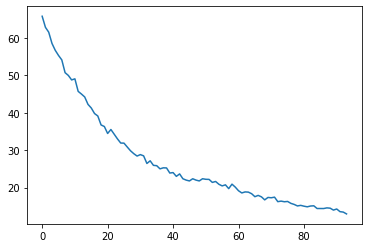

In [34]:
import matplotlib.pyplot as plt
# copy pasted this from another notebook instead of capturing because lazy

losses = [65.7486, 62.7873, 61.4920, 58.4905, 56.6521, 55.2771, 54.0909, 50.6875, 49.9440, 48.7508, 49.0366, 45.6912, 44.9796, 44.1981,
          42.2238, 41.2584, 39.7795, 39.1225, 36.728, 36.3127, 34.4518, 35.5149, 34.2678, 33.0167, 31.8986, 31.8731, 30.8363, 29.8315,
          29.0559, 28.4236, 28.8121, 28.4787, 26.4458, 27.1549, 25.9423, 25.8570, 25.0082, 25.2830, 25.2531, 23.8890, 24.0143, 23.0027, 
          23.6564, 22.3643, 22.0054, 21.7818, 22.3664, 22.0054, 21.7818, 22.3664, 22.2214, 22.1919, 21.3890, 21.6411, 20.8921, 20.4594, 
          20.7399, 19.7299, 20.9234, 20.1359, 19.1607, 18.5770, 18.8490, 18.7957, 18.3729, 17.5775, 17.9202, 17.5374, 16.7284, 17.3752,
         17.2874, 17.4525, 16.2492, 16.3944, 16.2279, 16.3034, 15.7949, 15.5133, 15.1075, 15.2623, 15.0426, 14.8753, 15.0869, 15.1444, 14.421,
         14.421, 14.4156, 14.59, 14.51, 14.000, 14.2922, 13.5836, 13.4663, 12.9784]

plt.plot(losses)

In [38]:
torch.save(model.state_dict(), './state-dict.pth',)

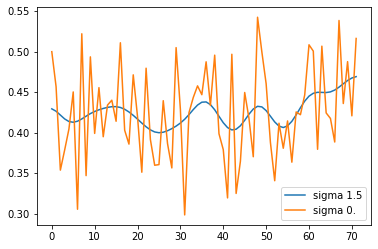

In [4]:
# losses = [.5, .4568, .3538, .3786, .4046, .4503, .3055, .5221, .347, .4936, .3991, .4556, .3950, .4341, .4401, .4141,\
#           .511, .4030, .3859, .4714, .4197, .3512, .4796, .3916, .3598, .3606, .4395, .3865, .3565, .5050, .4287, .2985, .4247, \
#               .4434, .4578, .4469, .4875, .4336, .4957, .3987, .3791, .3195, .4968, .3250, .3648, .4496, .4175, \
#           .3703, .5425, .4998, .4605, .3880, .3407, .4117, .3808, .4145, .3636, .4256, .4222, .4466, .5085, .5007, \
#           .3795, .5068, .4244, .4176, .3885, .5385, .4360, .4877, .4208, .5163         
#          ]

# from scipy import ndimage
# import matplotlib.pyplot as plt

# smooth = ndimage.gaussian_filter1d(losses, 3)
# plt.plot(smooth, label='sigma 1.5')
# plt.plot(losses, label='sigma 0.')
# plt.legend()

In [ ]:
# From here below, testing functions to allow for per layer freezing or differential LR

In [35]:
named_layers = [
    'lm_head',
    'embed_positions',
    'contact_head',
    'emb_layer_norm_before',
    'emb_layer_norm_after',
    'embed_tokens',
] # then 32 transformer layers

named_layers += [f'transformer-{i}' for i in range(len(model.layers))]

In [ ]:
def get_layer_params(model, layer_description: Union[int, None], head: bool = False, pos_embed: bool = True, aa_embed: bool = True):
            
    """
    Returns parameters `layer_description` for the transformer layers or flags the freezing of the head and two embeddings with named args.
    I wanted this function to either just freeze a layer from its name or return it so that I could provide it to an optimizer. 
    Never finished.
    """
    
    if isinstance(layer_description, int) is None and layer_description != None:
        raise TypeError('Arg `layer_description` must be of type int.')
        
    if mode == 'freeze':
        in_group 
    
    if isinstance(layer_description, int):
        if layer_description > 33 or layer_description < 0:
            raise ValueError('Arg `layer_description` must be between 0 and 34.')
    
        for idx in range(len(model.layers)):
            if idx < layer_description:
                if mode == 'freeze':
                    model.layers[idx].requires_grad(False)
                elif mode == ''
    
    is_bool_checker = lambda el: isinstance(el, bool)
    for arg_name, var in zip(('head', 'pos_embed', 'aa_embed'), (head, pos_embed, aa_embed)):
        if isinstance(var, bool) is False:
            raise TypeError(f'Arg {ar_name} be of type bool.')
    
    if head:
        getattr(model, 'lm_head').requires_grad_(False)
    
    if pos_embed:
        getattr(model, 'embed_positions').requires_grad_(False)
    
    if aa_embed:
        getattr(model, 'embed_tokens').requires_grad_(False)
    

In [41]:
list(model.named_parameters())

[('embed_tokens.weight',
  Parameter containing:
  tensor([[ 0.0400, -0.0787, -0.1237,  ..., -0.0205,  0.0952,  0.1434],
          [-0.0255,  0.0207,  0.0418,  ..., -0.0434,  0.0045,  0.0602],
          [ 0.0125, -0.1013,  0.0591,  ...,  0.0138,  0.0934,  0.0736],
          ...,
          [-0.0197,  0.0026,  0.0323,  ..., -0.0438, -0.0165, -0.0336],
          [-0.0140, -0.0051, -0.0207,  ..., -0.0202, -0.0003, -0.0101],
          [-0.0214,  0.0134,  0.0395,  ..., -0.0057,  0.0037,  0.0643]],
         requires_grad=True)),
 ('layers.0.self_attn.k_proj.weight',
  Parameter containing:
  tensor([[ 0.0006,  0.0447, -0.0345,  ..., -0.0340,  0.0024, -0.0409],
          [-0.0117,  0.0563,  0.0225,  ...,  0.0378, -0.0242, -0.0344],
          [ 0.0146,  0.0299,  0.0226,  ..., -0.0519,  0.0083, -0.0126],
          ...,
          [ 0.2439, -0.0351,  0.0753,  ..., -0.2883,  0.1647,  0.4050],
          [-0.1716,  0.4006, -0.3696,  ..., -0.1650, -0.2449, -0.1517],
          [ 0.0258,  0.3433, -0.177